## Usando Keras para Construir uma Rede Neural

Nesse exercício utilizaremos uma rede neural para predizer diabetes usando a base de dados Pima Diabetes. Começaremos os exercícios treinando uma Floresta Aleatória para utilizar como um baseline da performance da rede. Em seguida, utilizaremos o pacote Keras para construir e treinar uma rede neural e comparar a performance. Vamos testar diferentes estruturas de rede e como isso impacta na performance, tempo de treinamento e nível de overfitting.

## UCI Pima Diabetes Dataset

* UCI ML Repositiory (http://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes)


### Attributes: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)

A base de dados possui 8 atributos e uma variável alvo representando uma classe binária

In [1]:
# Importando as bibliotecas necessárias
from __future__ import absolute_import, division, print_function  # Python 2/3 compatibility

import warnings
warnings.filterwarnings("ignore")


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns

%matplotlib inline

In [ ]:
## Importando Keras

from keras.models  import Sequential, K
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop

In [3]:
## Carregando a base de dados diretamente pela url

url = "http://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
names = ["times_pregnant", "glucose_tolerance_test", "blood_pressure", "skin_thickness", "insulin", 
         "bmi", "pedigree_function", "age", "has_diabetes"]
diabetes_df = pd.read_csv(url, names=names)

In [4]:
# Uma pequena olhada nos dados -- se aparecerem muitos "NaN" você pode estar com problemas de conexão
print(diabetes_df.shape)
diabetes_df.sample(5)

(768, 9)


,times_pregnant,glucose_tolerance_test,blood_pressure,skin_thickness,insulin,bmi,pedigree_function,age,has_diabetes
290,0,78,88,29,40,36.9,0.434,21,0
381,0,105,68,22,0,20.0,0.236,22,0
275,2,100,70,52,57,40.5,0.677,25,0
600,1,108,88,19,0,27.1,0.400,24,0
531,0,107,76,0,0,45.3,0.686,24,0


In [7]:
X = diabetes_df.iloc[:, :-1].values
y = diabetes_df["has_diabetes"].values

In [10]:
# Vamos dividir a base entre treino e teste (75%, 25%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11111)

In [8]:
np.mean(y), np.mean(1-y)

(0.34895833333333331, 0.65104166666666663)

In [11]:
np.mean(y_train), np.mean(1-y_train)

(0.3454861111111111, 0.65451388888888884)

In [12]:
np.mean(y_test), np.mean(1-y_test)

(0.359375, 0.640625)

Das estatísticas acima, percebemos que 35% dos pacientes da base tem diabetes e 65% não. Isso significa que podemos obter uma acurácia de 65% sem qualquer modelo, apenas predizendo que ninguém tem diabetes. Para validarmos nosso modelo de redes neurais, calcularemos o AUC e a acurácia para verificar se estamos acima de um baseline simples.

## Exercício: Gerando um baseline com Árvore Aleatória
Para iniciar:
1. Treine uma Floresta Aleatória (várias Árvores de Decisão combinadas) com 200 árvores na base de treino.
2. Calcule a acurácia e auc das predições.

In [8]:
## Treine a floresta aleatória
rf_model = RandomForestClassifier(???)
rf_model.fit(???)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [ ]:
# Faça predições 0/1 e probabilísticas
y_pred_class_rf = rf_model.predict(???)
y_pred_prob_rf = rf_model.predict_proba(???)


print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_rf)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_rf[:,1])))

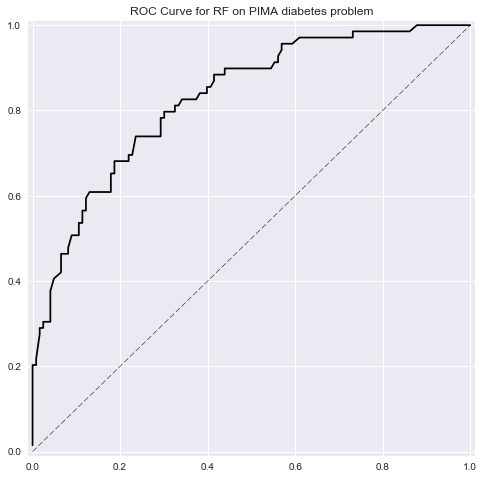

In [10]:
# Vamos plotar a curva ROC-AUC para validar nosso modelo
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on PIMA diabetes problem'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])


plot_roc(y_test, y_pred_prob_rf[:, 1], 'RF')

## Construindo uma Rede Neural com uma camada escondida

Utilizaremos o modelo Sequential para construir rapidamente uma rede neural. Nossa primeira rede será uma rede neural de uma única camada. Temos 8 variáveis de entrada, então a input shape deve ser 8. Vamos começar com uma única camada escondida com 12 nós.

In [11]:
## Primeiro vamos normalizar os dados
## Isso ajuda o algoritmo de otimização a obter estabilidade numérica.
## Como as Árvores de Decisão trabalham com a divisão de valores atributo a atributo, isso não afeta sua performance

normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(???)
X_test_norm = normalizer.transform(???)

In [12]:
# Vamos construir o modelo
# Input size tem dimensão 8
# 1 camada escondida, 12 neurônios, ativação sigmoid
# A camada final tem apenas um nó com ativação sigmoid (padrão para classificação binária)

model_1 = Sequential([
    Dense(??, input_shape=(??,), activation=??),
    Dense(??, activation=??)
])

In [13]:
#  Vamos verificar um resumo da rede

model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                108       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


### Questão de compreensão:

Por que  temos 121 parâmetros? Faz sentido?


Vamos ajustar nosso modelo por 200 iterações.

In [ ]:
# Vamos compilar com um otimizador, função de erro e métrica de avaliação
# Roc-Auc não está disponível no Keras, vamos pular seu uso por ora

model_1.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_1 = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=200)
# o método fit retorna um histórico que pode ser útil para análise dos parâmetros do modelo

In [ ]:
## Da mesma forma que fizemos com o Random Forest, vamos gerar as predições
#  com predict_classes (0/1) e predict (probabilidade)

y_pred_class_nn_1 = model_1.predict_classes(??)
y_pred_prob_nn_1 = model_1.predict(??)

In [ ]:
# Vamos verificar as 10 primeiras predições
y_pred_class_nn_1[:10]

In [ ]:
y_pred_prob_nn_1[:10]

accuracy is 0.766
roc-auc is 0.805


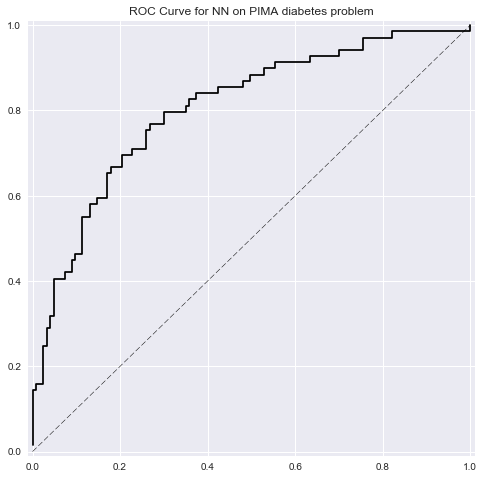

In [18]:
# Vamos imprimir a acurácia, roc-auc e plotar a curva ROC-AUC
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

Podem haver variações nos números exatos por conta da aleatoriedade, mas você deve obter resultados similares ao Random Forest, entre 75% e 85% de acurácia e entre .8 e .9 para auc.

Vamos ver o que o objeto  `run_hist_1`  contém.

In [19]:
run_hist_1.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

Vamos utilizar o histórico para plotar o erro de treino ao longo das gerações.

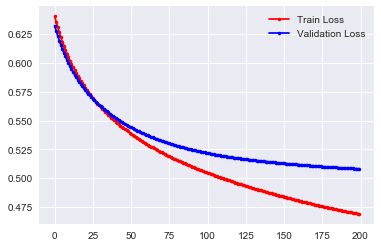

In [20]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

Reparem que os erros parecem estar caindo tanto para o conjunto de treino como de validação. Isso sugere que o modelo ainda poderia melhorar com mais algumas gerações.

Vamos treinar o modelo um pouco mais, note que ele não reinicia do zero, mas começará de onde parou. Treine por mais 1000 iterações.

In [ ]:
## Note that when we call "fit" again, it picks up where it left off
run_hist_1b = model_1.fit(???, ???, validation_data=(???), epochs=???)

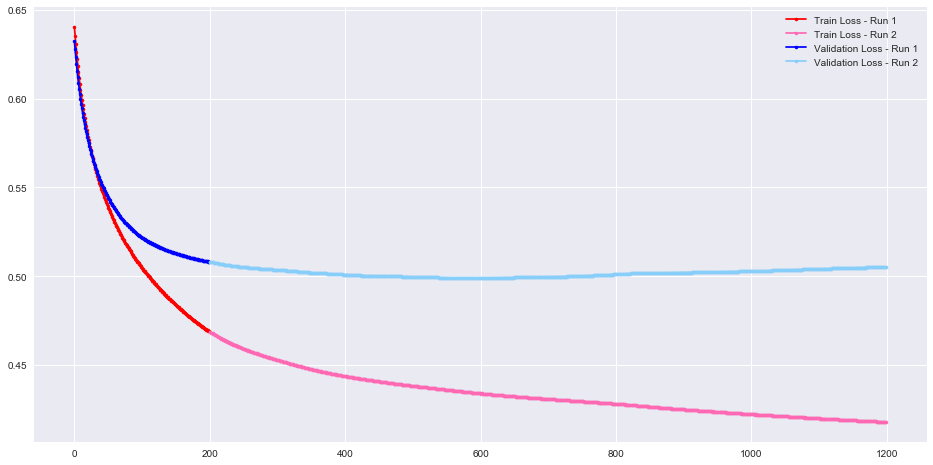

In [22]:
n = len(run_hist_1.history["loss"])
m = len(run_hist_1b.history['loss'])
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(range(n), run_hist_1.history["loss"],'r', marker='.', label="Train Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["loss"], 'hotpink', marker='.', label="Train Loss - Run 2")

ax.plot(range(n), run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["val_loss"], 'LightSkyBlue', marker='.',  label="Validation Loss - Run 2")

ax.legend()

Agora, enquanto o erro de treino continua caindo, o de validação parece ter começado a piorar. Isso sugere que não devemos continuar com o treino. Qual o número apropriado de iterações?

## Exercício

Repita os experimentos anteriores, sem ajuda:
- Construa um modelo com duas camadas escondidas, cada uma com 6 nós
- Use a ativação "relu" nas camadas escondidas e "sigmoid" para a camada final
- Com uma taxa de aprendizado de .003 treine por 1500 iterações
- Plote o erro e a acurácia na base de treino e teste ao longo das iterações
- Plote a curva ROC-AUC para as predições

Teste diferentes taxas de aprendizado, número de iterações e estruturas de rede